In [ ]:
%%capture
!pip3 install tclab --upgrade

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output/lstm_model_100_mins.h5 .
!cp /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output/lstm_model_params_100_mins.pkl .

# Imports

In [ ]:
import tclab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pickle
from tqdm.notebook import tqdm

from keras.models import load_model

In [ ]:
# Setup for gif animation
import imageio
import os
try:
    os.mkdir('./figures')
except:
    pass

# setup paths
model_path = "/content/lstm_model_100_mins.h5"
model_params_path = "/content/lstm_model_params_100_mins.pkl"
mins = model_path.split("_")[-2]

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


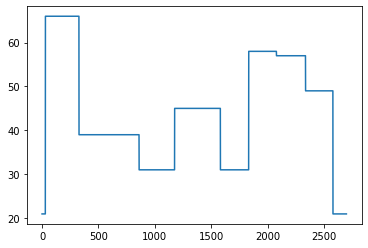

In [ ]:
#### Set up run ####

# Import model and model parameters
model = load_model(model_path)
model_params = pickle.load(open(model_params_path, 'rb'))

s_x = model_params['Xscale']
s_y = model_params['yscale']
window = model_params['window']

# Run time in minutes
run_time = 45.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Qpid = np.zeros(loops) # Heater values for PID controller
Qlstm = np.zeros(loops) # Heater values for LSTM controller
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with tclab.TCLabModel() as lab:
    Tsp = np.ones(loops) * lab.T1

# vary temperature setpoint
end = window + 15 # leave 1st window + 15 seconds of temp set point as room temp
while end <= loops: 
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Tsp[start:end] = random.randint(30,70)
    
# leave last 120 seconds as room temp
Tsp[-120:] = Tsp[0]

plt.plot(Tsp);

# Run the controller with the PID

In [ ]:
# PID Parameters
Kc   = 6.0
tauI = 75.0 # sec
tauD = 0.0  # sec

#-----------------------------------------
# PID Controller
#-----------------------------------------

def pid(sp,pv,pv_last,ierr,dt):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD
    
    # ubias for controller (initial heater)
    op0 = 0 
    
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error
    ierr = ierr + KI * error * dt
    
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
        
    # return the controller output and PID terms
    return [op,P,I,D]

In [ ]:
#-----------------------------------------
# LSTM Controller
#-----------------------------------------

def lstm(T1_m, Tsp_m):
    # Calculate error (necessary feature for LSTM input)
    err = Tsp_m - T1_m
    
    # Format data for LSTM input
    X = np.vstack((Tsp_m,err)).T
    Xs = s_x.transform(X)
    Xs = np.reshape(Xs, (1, Xs.shape[0], Xs.shape[1]))
    
    # Predict Q for controller and unscale
    Q1c_s = model.predict(Xs)
    Q1c = s_y.inverse_transform(Q1c_s)[0][0]
    
    # Ensure Q1c is between 0 and 100 (because of heater capacity)
    Q1c = np.clip(Q1c,0.0,100.0)
    
    return Q1c

In [ ]:
# Run test
with tclab.TCLabModel() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0

    start_time = time.time()
    prev_time = start_time

    for i in tqdm(range(loops)):
        # Delay 1 second
        if time.time() > prev_time + 1.0:
            print('Exceeded cycle time by ',time.time()-prev_time-1.0)
        else:
            while time.time() < prev_time + 1.0:
                pass
        
        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperature (C)
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp[i]-T1[i])

        # Calculate PID output
        [Qpid[i],P,ierr,D] = pid(Tsp[i],T1[i],T1[i-1],ierr,dt)

        # Write heater output (0-100)
        lab.Q1(Qpid[i])
        
        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp_m = Tsp[i-window:i]
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(T1_m,Tsp_m)
            
        # Generate images to make a gif; only need every 10 images
        if i%10 == 0:
            plt.figure(figsize=(10,8))
            plt.plot(Tsp,'k-',label='SP $(^oC)$')
            plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
            plt.plot(Qpid[:i],'b-',label='$Q_{PID}$ (%)')
            plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
            plt.legend(loc='upper right',fontsize=14)
            plt.ylim((0,100))
            plt.xlabel('Time (s)',size=14)
            plt.xticks(size=12)
            plt.yticks(size=12)

            num = str(i)
            num = num.zfill(len(str(loops)))
            filename='./figures/pid_'+num+'.png'
            plt.savefig(filename)
            plt.close()

TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.63 °C


  0%|          | 0/2700 [00:00<?, ?it/s]

Exceeded cycle time by  0.7921802997589111
TCLab Model disconnected successfully.


In [ ]:
# Generate gif from saved images
images = []
for i in range(0,loops,10):
    num = str(i)
    num = num.zfill(len(str(loops)))
    filename='./figures/pid_'+num+'.png'
    images.append(imageio.imread(filename))
imageio.mimsave(f'pid_controller_{mins}_mins.gif', images)

In [ ]:
!cp /content/pid_controller_{mins}_mins.gif /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output/
!cp /content/lstm_controller_{mins}_mins.gif /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output/

In [ ]:
# !rm -rf figures/